<a href="https://colab.research.google.com/github/leehyeonjin99/BOOSTCAMP_AI_Tech_Study_Diary/blob/main/%EB%85%BC%EB%AC%B8review/Network%20%EA%B5%AC%ED%98%84/ResNet_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ResNet 설계

In [1]:
import torch
import torch.nn as nn

In [2]:
class BasicBlock(nn.Module):
  mul=1
  def __init__(self, in_channel, out_channel, stride=1):
    super(BasicBlock, self).__init__()

    self.conv1=nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, bias=False)
    self.conv2=nn.Conv2d(out_channel, out_channel, 3, stride=1, padding=1, bias=False)

    self.bn1=nn.BatchNorm2d(out_channel)
    self.bn2=nn.BatchNorm2d(out_channel)

    self.relu1=nn.ReLU()
    self.relu2=nn.ReLU()

    self.shortcut=nn.Sequential()
    if stride!=1 or in_channel!=out_channel:
      self.shortcut=nn.Sequential(nn.Conv2d(in_channel, out_channel, 1, stride=stride),
                                  nn.BatchNorm2d(out_channel))
    
  def forward(self, x):
    out=self.conv1(x)
    out=self.bn1(out)
    out=self.relu1(out)
    out=self.conv2(out)
    out=self.bn2(out)
    out+=self.shortcut(x)
    out=self.relu2(out)
    return out

In [3]:
class BottleNeck(nn.Module):
  mul=4
  def __init__(self, in_channel, out_channel, stride=1):
    super(BottleNeck, self).__init__()

    self.conv1=nn.Conv2d(in_channel, out_channel, 1, stride=1, bias=False)
    self.conv2=nn.Conv2d(out_channel, out_channel, 3, stride=stride, padding=1, bias=False)
    self.conv3=nn.Conv2d(out_channel, out_channel*self.mul, 1, stride=1, bias=False)

    self.bn1=nn.BatchNorm2d(out_channel)
    self.bn2=nn.BatchNorm2d(out_channel)
    self.bn3=nn.BatchNorm2d(out_channel*self.mul)

    self.relu1=nn.ReLU()
    self.relu2=nn.ReLU()
    self.relu3=nn.ReLU()

    self.shortcut=nn.Sequential()
    if stride!=1 or in_channel!=out_channel*self.mul:
      self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel*BottleNeck.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel*BottleNeck.mul)
            )
      
  def forward(self, x):
    out=self.conv1(x)
    out=self.bn1(out)
    out=self.relu1(out)
    out=self.conv2(out)
    out=self.bn2(out)
    out=self.relu2(out)
    out=self.conv3(out)
    out=self.bn3(out)
    out+=self.shortcut(x)
    out=self.relu3(out)
    return out

In [4]:
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()

    self.in_channel=64

    self.conv1=nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1=nn.BatchNorm2d(self.in_channel)
    self.maxpool1=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1=self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2=self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3=self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4=self._make_layer(block, 512, num_blocks[3], stride=2)

    self.avgpool=nn.AdaptiveAvgPool2d((1,1))
    self.linear=nn.Linear(512*block.mul,num_classes)
  
  def _make_layer(self, block, out_channel, num_block, stride):
        layers  = [ block(self.in_channel, out_channel, stride) ]
        self.in_channel = block.mul * out_channel
        for i in range(num_block - 1):
            layers.append(block(self.in_channel, out_channel, 1))
            self.in_channel=out_channel*block.mul
        return nn.Sequential(*layers)

  def forward(self, x):
    out=self.conv1(x)
    #print(out.size())
    out=self.bn1(out)
    out=torch.nn.functional.relu(out)
    out=self.maxpool1(out)
    #print(out.size())
    out=self.layer1(out)
    #print(out.size())
    out=self.layer2(out)
    #print(out.size())
    out=self.layer3(out)
    #print(out.size())
    out=self.layer4(out)
    #print(out.size())
    out=self.avgpool(out)
    #print(out.size())
    out=torch.flatten(out, 1)
    #print(out.size())
    out=self.linear(out)
    return out

In [5]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [6]:
resnet=ResNet50()
x=torch.randn((1,3,224,224))
resnet(x)

tensor([[-0.2319,  0.2386,  0.3135, -0.7152,  0.6220, -0.8905, -0.0422, -0.5503,
         -0.5824,  0.6591]], grad_fn=<AddmmBackward0>)

## CIFAR 학습

In [8]:
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

In [30]:
transform_train=transforms.Compose([transforms.RandomCrop(32, padding=4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor()])

transform_test=transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [31]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
model=ResNet50()

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (relu2): ReLU()
      (relu3): ReLU()
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [32]:
model.to(device)
num_epoch=150
model_name='model.pth'

loss=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

train_loss=0
valid_loss=0
correct=0
total_cnt=0
best_acc=0

In [33]:
for epoch in range(20):
  print(f"======{epoch+1} epoch of {20}======")
  model.train()
  train_loss=0
  valid_loss=0
  correct=0
  total_cnt=0

  for step, (X, y) in enumerate(train_loader):
    X=X.to(device)
    y=y.to(device)

    predict=model(X)
    L=loss(predict, y)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()

    train_loss+=L.item()
    pred = torch.argmax(predict, dim=1)
    total_cnt+=y.size(0)
    correct+=torch.sum(pred==y).sum()

  print(f"Train Acc : {correct/total_cnt}")
  print(f"Train Loss : {L.item()/y.size(0)}")

======1 epoch of 20======


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Acc : 0.34369999170303345
Train Loss : 0.021021613478660585
======2 epoch of 20======
Train Acc : 0.47679999470710754
Train Loss : 0.016913872957229615
======3 epoch of 20======
Train Acc : 0.36403998732566833
Train Loss : 0.022632455825805663
======4 epoch of 20======
Train Acc : 0.35763999819755554
Train Loss : 0.019592751562595368
======5 epoch of 20======
Train Acc : 0.4213999807834625
Train Loss : 0.020733968913555147
======6 epoch of 20======
Train Acc : 0.48721998929977417
Train Loss : 0.016411039233207702
======7 epoch of 20======
Train Acc : 0.5119199752807617
Train Loss : 0.013726480305194855
======8 epoch of 20======
Train Acc : 0.5247200131416321
Train Loss : 0.01615239679813385
======9 epoch of 20======
Train Acc : 0.5742999911308289
Train Loss : 0.013468238711357116
======10 epoch of 20======
Train Acc : 0.5292400121688843
Train Loss : 0.03257322013378143
======11 epoch of 20======
Train Acc : 0.5103799700737
Train Loss : 0.013678854703903199
======12 epoch of 20===

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(7)


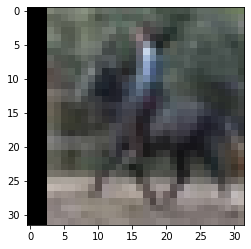

In [41]:
import numpy as np

data=next(iter(train_loader))
import matplotlib.pyplot as plt
plt.imshow(np.transpose(data[0][1].numpy(), (1,2,0)))
print(data[1][1])

In [57]:
model.eval()
hypothesis=model(data[0].to(device))
pred=torch.argmax(hypothesis, dim=1)

In [61]:
(data[1].to(device)==pred).sum()/len(data[1])

tensor(0.7148, device='cuda:0')